# Exploring the GIPHY.com Metadata

This notebook demonstrates an intermediate approach to exploring the GIPHY.com data set produced by the Library of Congress. GIPHY.com is a site that has been archived by the Library of Congress in its Web Cultures archive. The data explored here is available from the LC Labs experiments page located here: https://labs.loc.gov/experiments/webarchive-datasets/. 

As an intermediate approach, this notebook uses functions as reuseable blocks of code. These functions could potentially be used outside of this notebook to help you explore the data further. 

If you're looking for more of a beginner's approach, check out the Meme Generator notebook, which explores the memegenerator.net data set, also produced by the Library of Congress.

This notebook is divided into the following sections:

1. Setting up the Environment
2. Defining the Functions
3. Running the Functions

# Setting up the Environment


## Module Imports

Below are all the `import` statements we'll need in order perform some basic computations over the GIPHY data set. They are broken out into sections based on their use in this notebook. You will need to install the following Python modules:

* matplotlib
* tqdm

### Reading, Writing, and Getting

The `import` statements below are for modules that we'll use to get and read in the `giphy.csv`.

In [1]:
import csv
import os
import zipfile

### Processing

The following `import` statements will help in the processing, sorting, and counting of the information from the data set.

In [2]:
from collections import Counter
from datetime import datetime
import operator
from tqdm import tqdm
from urllib.request import urlretreive
from time import sleep

### Visualizing the Results

The following `import` statements allow for us to visual the processes we'll be running.

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
from random import choice

ModuleNotFoundError: No module named 'matplotlib'

# Defining the Functions

Below are four functions that we'll use in our exploration of the GIPHY data set.

## get_giphy_data_set

This function checks to see if the giphy data set is present. The path it checks and the location to which it eventually downloads and unzips the data set can be modified, if desired. But by default, the function checks for a folder called `giphy-dataset` in the current working directory and for a file called `giphy.csv` within that folder.

If the folder and file are present, nothing is done because the data set is already downloaded and extracted. If it's not, then the function navigations to the data set's downloadable URL, and saves the file as `giphy-dataset.zip` in the current working directory.

Then, the function unzips the folder in the current working directory to create a folder called `giphy-dataset`, which contains the dataset file: `giphy.csv`.

In [6]:
def get_giphy_data_set():
    if not os.path.exists('giphy-dataset/giphy.csv'):
        urlretrieve('https://s3.us-east-2.amazonaws.com/lclabspublicdata/giphy-dataset.zip', 'giphy-dataset.zip')
        z = zipfile.ZipFile('giphy-dataset.zip', 'r')
        z.extractall('./')
        z.close()

## load_giphy_data_set

As the name implies, this function loads, or reads in, the data set as a list of lists--where each row in the data set is a list of each cell in that row. This list of lists is stored as a variable and return as the output of the function.

This function utilizes prior knowledge of the data set, which may elude first-time users. For instance:
The data set is read in under a `utf16` encoding.

Additionally, you'll see that a delimiter is set to the value equivalent of a tab. That is because the rows' cells are tab, not comma, separated. This again, was due to certain constraints where creating and saving the original data set.

In [3]:
def load_giphy_data_set():
    data = []
    if os.path.exists('giphy-dataset/giphy.csv'):
        with open('giphy-dataset/giphy.csv', 'r+', encoding='utf16') as f:
            for row in csv.DictReader(f, delimiter='\t'):
                data.append(dict(row))
    return data

## get_import_dates

The following function will grab all the values from the `Import Date` column of the data set and turn the string `m/dd/yyyy` into a [`datetime` object](https://docs.python.org/3.7/library/datetime.html) that can be grouped and sorted chronologically. 

The function takes the data set as a parameter and will return a dictionary of dates and the frequency of their occurrence. 

In [6]:
def get_import_dates(data):
    results = []
    for row in data:
        # The Import Date field is structured like so: m/dd/yyyy H:M
        # We're not interested in the hours or minutes, so we split the string
        # on the empty space, creating a list: ['m/dd/yyyy', 'H:M'].
        # However, we only want the first item in the list, so we specify that
        # by adding [0] after the split.
        string_date = row['Import Date'].split()[0]
        # We don't want the entries that are listed as 'NA'
        # and since 1970 is a default date, we don't want to 
        # count those either.
        # All other dates are added.
        if string_date != 'NA' and '1970'not in string_date:
            date = datetime.strptime(string_date, '%m/%d/%Y')
            results.append(date)
    dates = dict(Counter(results))
    dates = sorted(dates.items(), key=operator.itemgetter(0))
    results = []
    # we only want to include the dates that have more than 35 GIFs associated with them.
    # Otherwise, the tail of the data gets very long. In fact, doing this limits
    # the results to just 44 dates.
    for date_pair in dates:
        if date_pair[1] > 35:
            results.append(date_pair)
    return results

## create_bar_chart_from_distribution

The following function creates a bar chart from a distribution object, that is, a list of tuples wherein the first item is a value and the second item in the tuple is the number of times that value occurred in the distribution. 

It takes an optional parameter of title for the chart.

In [7]:
def create_bar_chart_from_distributions(dist, title=None):
    # This is bit of code in the brackets, is just a fancy way
    # of creating a list with a for loop. It's called a list comprehension.
    # All it is doing is looping through the tuples in the dist variable
    # and assigning the first item in that tuple to the list, which is then
    # stored in the variable x_values
    x_values = [pair[0] for pair in dist]
    y_pos = np.arange(len(x_values))
    # Similar to x_values, except the second value from the tuple is stored
    # in the list
    freq = [pair[1] for pair in dist]
    # Assigns all the colors from the Matplotlib's XKCD's color dictionary to a list
    colors = list(mpl.colors.XKCD_COLORS.values())
    # We're using another list comprehension to randomly choose a color for each item in x_values
    colors = [choice(colors) for i in x_values]
    plt.bar(y_pos, freq, align='center', alpha=.5, color=colors)
    plt.xticks(y_pos, x_values, fontsize=35, rotation='vertical')
    plt.yticks(fontsize=35)
    plt.ylabel('Frequency', fontsize=35)
    if title:
        plt.title(title, fontsize=35)   

# Running the Functions

Now that we've defined the functions, we can run them.

### 1) Get the Data Set
Call the `get_giphy_data_set` function that will download and extract the data set for us

In [8]:
get_giphy_data_set()

### 2) Load the Data Set
Now that the data set is downloded and extracted, call the `load_giphy_data_set` function that reads in and returns the GIPHY data set as a list of dictionary objects.

In [4]:
giphy_data_set = load_giphy_data_set()

### Preview of the `giphy_data_set` content

In [7]:
giphy_data_set[0:2]

[{'GIF ID': '1000eGIbYHercI',
  'Web Archive Link': 'http://webarchive.loc.gov/all/20150318155641/http://media.giphy.com/media/1000eGIbYHercI/giphy.gif',
  'MD5 Hash': 'b9a248bc783052ba1ccf29c5a9ac9ed1',
  'File Size (In Bytes)': '1508448',
  'GIPHY Title': 'slipper GIF',
  'Import Date': '9/21/2013 3:37',
  'Trending Date': '1/1/1970 0:00'},
 {'GIF ID': '1000fHsBSKSL6w',
  'Web Archive Link': 'http://webarchive.loc.gov/all/20150318155641/http://media.giphy.com/media/1000fHsBSKSL6w/giphy.gif',
  'MD5 Hash': '91d00a6dd66f7fa8e6d132601a9778e1',
  'File Size (In Bytes)': '547019',
  'GIPHY Title': 'swag hustling GIF',
  'Import Date': '6/22/2015 5:35',
  'Trending Date': '1/12/2016 23:45'}]

In [11]:
import_dates = get_import_dates(giphy_data_set)

### 3) Chart the Import Dates
We'll chart the Import Dates collected, counted, sorted, and stored in the `import_dates` variable. We'll pass that variable into the `create_bar_chart_from_distributions`.

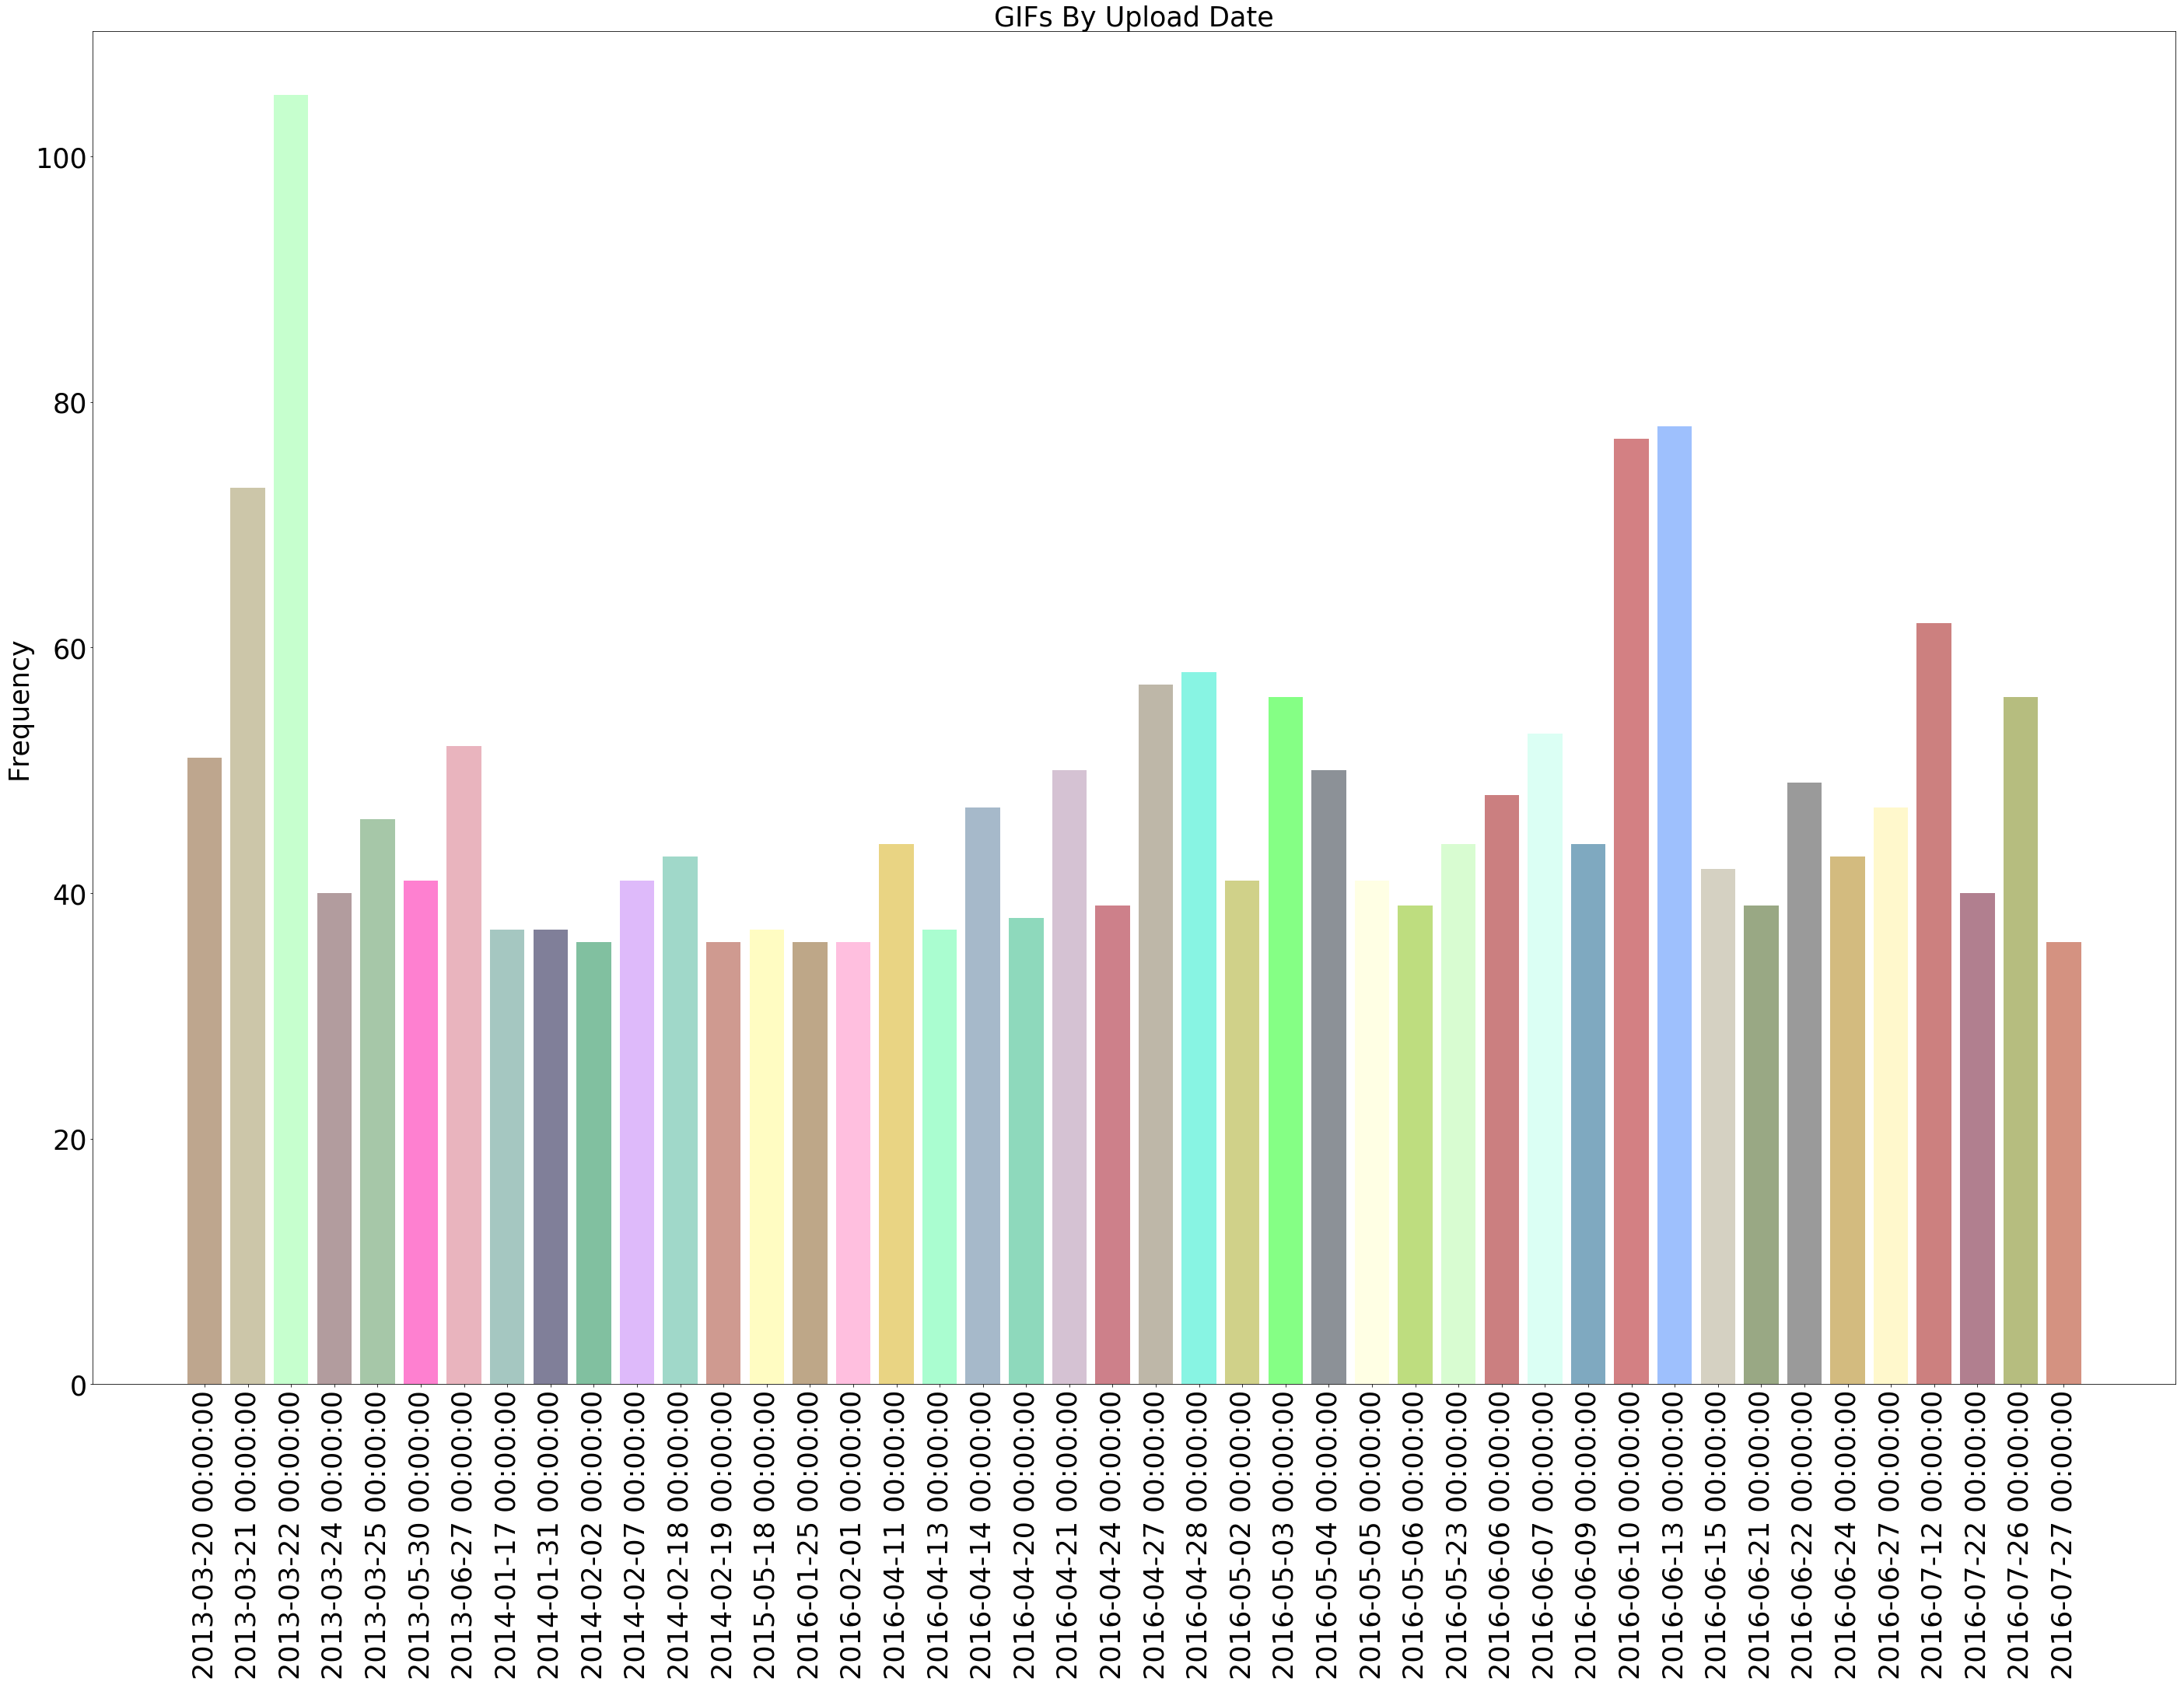

In [12]:
plt.rcParams["figure.figsize"] = (48.0, 32.0)
create_bar_chart_from_distributions(import_dates, title='GIFs By Upload Date')

### 4) Hydrate the Dataset

Finally we will download all the GIFs to your workstation for you to use. There are 10,972 of them, and we will pause a little bit between image downloads so as not to overload LC's webarchive server, so it'll take a while!

First lets make a directory to put the GIFs (`files/gifs`):

In [ ]:
gifs_dir = os.path.join('files/gifs')
if not os.path.isdir(gifs_dir):
    os.mkdir(gifs_dir)

Now lets iterate through our dataset and download each one. They will be downloaded to the `files/gifs` directory. We use [tqdm](https://github.com/tqdm/tqdm) to provide a progress bar so you know something is happening.

In [7]:
progress = tqdm(total=len(giphy_data_set), unit='gif')

for gif in giphy_data_set:
    progress.update(1)
    
    gif_id = gif['GIF ID']
    gif_url = gif['Web Archive Link']
    
    filename = os.path.join(gifs_dir, '{}.gif'.format(gif_id))
    if os.path.isfile(filename):
        continue
        
    urlretrieve(gif_url, os.path.join(gifs_dir, '{}.gif'.format(gif_id)))
    sleep(.5)
    


 23%|██▎       | 2566/10972 [00:02<00:08, 996.47gif/s]

KeyboardInterrupt: 

We hope that this notebook has helped you understand and explore this dataset! As you continue to explore, we'd love to hear about anything interesting and cool that you make. You can contact us by leaving a comment on the Library of Congress' The Signal blog (http://blogs.loc.gov/thesignal/) or through our contact form at https://www.loc.gov/programs/web-archiving/about-this-program/contact-us/. 

You can read more about how Library of Congress staff analyzed this data set in this post on The Signal blog: http://blogs.loc.gov/thesignal/2018/10/data-mining-memes-in-the-digital-culture-web-archive/. Have fun exploring these memes in more detail!

**Contributors:**
- Chase Dooley
- Jesse Johnston
- Aly DesRochers